In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from collections import defaultdict

class TicTacToeEnvironment:
    """Tic-Tac-Toe game environment"""
    
    def __init__(self):
        self.board = [' '] * 9
        self.current_player = 'X'
        
    def reset(self):
        """Reset the board"""
        self.board = [' '] * 9
        self.current_player = 'X'
        return self.get_state()
    
    def get_state(self):
        """Return current board state as string"""
        return ''.join(self.board)
    
    def get_available_actions(self):
        """Return list of available positions"""
        return [i for i, cell in enumerate(self.board) if cell == ' ']
    
    def make_move(self, position, player):
        """Make a move on the board"""
        if self.board[position] == ' ':
            self.board[position] = player
            return True
        return False
    
    def check_winner(self):
        """Check if there's a winner. Returns 'X', 'O', 'draw', or None"""
        winning_combinations = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # columns
            [0, 4, 8], [2, 4, 6]              # diagonals
        ]
        
        for combo in winning_combinations:
            if (self.board[combo[0]] == self.board[combo[1]] == self.board[combo[2]] != ' '):
                return self.board[combo[0]]
        
        if ' ' not in self.board:
            return 'draw'
        
        return None
    
    def print_board(self):
        """Print the current board"""
        print("\n")
        for i in range(0, 9, 3):
            print(f" {self.board[i]} | {self.board[i+1]} | {self.board[i+2]} ")
            if i < 6:
                print("-----------")
        print("\n")


class QLearningAgent:
    """Q-Learning agent for Tic-Tac-Toe"""
    
    def __init__(self, player='X', learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.player = player
        self.opponent = 'O' if player == 'X' else 'X'
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = defaultdict(float)
        
    def get_q_value(self, state, action):
        """Get Q-value for state-action pair"""
        return self.q_table[(state, action)]
    
    def choose_action(self, state, available_actions, training=True):
        """Choose action using epsilon-greedy strategy"""
        if not available_actions:
            return None
        
        # Exploration: random action
        if training and random.random() < self.epsilon:
            return random.choice(available_actions)
        
        # Exploitation: best action based on Q-values
        q_values = [self.get_q_value(state, action) for action in available_actions]
        max_q = max(q_values)
        
        # If multiple actions have same max Q-value, choose randomly among them
        best_actions = [action for action, q in zip(available_actions, q_values) if q == max_q]
        return random.choice(best_actions)
    
    def update_q_value(self, state, action, reward, next_state, next_available_actions):
        """Update Q-value using Q-learning formula"""
        current_q = self.get_q_value(state, action)
        
        # Calculate max Q-value for next state
        if next_available_actions:
            max_next_q = max([self.get_q_value(next_state, a) for a in next_available_actions])
        else:
            max_next_q = 0
        
        # Q-learning update rule
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[(state, action)] = new_q
    
    def save_model(self, filename='tictactoe_agent.pkl'):
        """Save Q-table to file"""
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.q_table), f)
        print(f"Model saved to {filename}")
    
    def load_model(self, filename='tictactoe_agent.pkl'):
        """Load Q-table from file"""
        try:
            with open(filename, 'rb') as f:
                self.q_table = defaultdict(float, pickle.load(f))
            print(f"Model loaded from {filename}")
            return True
        except FileNotFoundError:
            print(f"File {filename} not found. Starting with empty Q-table.")
            return False


class RandomAgent:
    """Random agent for opponent"""
    
    def __init__(self, player='O'):
        self.player = player
    
    def choose_action(self, state, available_actions, training=True):
        """Choose random action"""
        return random.choice(available_actions) if available_actions else None


def train_agent(episodes=10000, save_model=True):
    """Train the Q-learning agent"""
    env = TicTacToeEnvironment()
    agent = QLearningAgent(player='X')
    opponent = RandomAgent(player='O')
    
    wins = 0
    losses = 0
    draws = 0
    
    # Track statistics for plotting (every 100 episodes)
    win_rates = []
    loss_rates = []
    draw_rates = []
    episode_numbers = []
    
    # Rolling statistics for smoother curves
    window_size = 100
    recent_results = []  # Store recent game results
    
    print("Training started...")
    print("="*60)
    
    for episode in range(episodes):
        env.reset()
        done = False
        game_result = None
        
        while not done:
            # Agent's turn
            state = env.get_state()
            available_actions = env.get_available_actions()
            
            if not available_actions:
                break
            
            action = agent.choose_action(state, available_actions, training=True)
            
            if action is None:
                break
            
            env.make_move(action, agent.player)
            winner = env.check_winner()
            
            # Check if game ended after agent's move
            if winner == agent.player:
                reward = 1  # Win
                agent.update_q_value(state, action, reward, env.get_state(), [])
                wins += 1
                game_result = 'win'
                done = True
                break
            elif winner == 'draw':
                reward = 0.5  # Draw
                agent.update_q_value(state, action, reward, env.get_state(), [])
                draws += 1
                game_result = 'draw'
                done = True
                break
            
            # Opponent's turn
            opponent_available = env.get_available_actions()
            if not opponent_available:
                break
                
            opponent_action = opponent.choose_action(env.get_state(), opponent_available)
            if opponent_action is None:
                break
            
            env.make_move(opponent_action, opponent.player)
            next_state = env.get_state()
            next_available_actions = env.get_available_actions()
            winner = env.check_winner()
            
            # Check if game ended after opponent's move
            if winner == opponent.player:
                reward = -1  # Loss
                agent.update_q_value(state, action, reward, next_state, [])
                losses += 1
                game_result = 'loss'
                done = True
            elif winner == 'draw':
                reward = 0.5  # Draw
                agent.update_q_value(state, action, reward, next_state, [])
                draws += 1
                game_result = 'draw'
                done = True
            else:
                reward = 0  # Game continues
                agent.update_q_value(state, action, reward, next_state, next_available_actions)
        
        # Track rolling window results
        if game_result:
            recent_results.append(game_result)
            if len(recent_results) > window_size:
                recent_results.pop(0)
        
        # Record statistics every 100 episodes
        if (episode + 1) % 100 == 0:
            # Calculate rates based on rolling window for smoother curves
            if len(recent_results) > 0:
                window_wins = recent_results.count('win')
                window_losses = recent_results.count('loss')
                window_draws = recent_results.count('draw')
                window_total = len(recent_results)
                
                win_rates.append((window_wins / window_total) * 100)
                loss_rates.append((window_losses / window_total) * 100)
                draw_rates.append((window_draws / window_total) * 100)
            else:
                win_rates.append(0)
                loss_rates.append(0)
                draw_rates.append(0)
            
            episode_numbers.append(episode + 1)
            
            # Print progress
            overall_win_rate = (wins / (episode + 1)) * 100
            print(f"Episode {episode + 1:5d}/{episodes} | "
                  f"Overall: W:{wins:4d} L:{losses:4d} D:{draws:4d} | "
                  f"Win Rate: {overall_win_rate:5.1f}% | "
                  f"Q-table: {len(agent.q_table):5d} entries")
    
    print("="*60)
    print(f"\n✅ Training completed!")
    print(f"Final Results:")
    print(f"  Wins:   {wins:5d} ({wins/episodes*100:5.1f}%)")
    print(f"  Losses: {losses:5d} ({losses/episodes*100:5.1f}%)")
    print(f"  Draws:  {draws:5d} ({draws/episodes*100:5.1f}%)")
    print(f"  Q-table size: {len(agent.q_table)} state-action pairs")
    
    if save_model:
        agent.save_model()
    
    # Create visualization
    fig = plt.figure(figsize=(14, 6))
    
    # Plot 1: Performance over time
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(episode_numbers, win_rates, label='Win Rate', color='#10b981', linewidth=2.5)
    ax1.plot(episode_numbers, loss_rates, label='Loss Rate', color='#ef4444', linewidth=2.5)
    ax1.plot(episode_numbers, draw_rates, label='Draw Rate', color='#f59e0b', linewidth=2.5)
    ax1.set_xlabel('Episodes', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Rate (%) - Rolling 100 game average', fontsize=12, fontweight='bold')
    ax1.set_title('Training Performance Over Time', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xlim(0, episodes)
    ax1.set_ylim(0, 100)
    
    # Plot 2: Final results pie chart
    ax2 = plt.subplot(1, 2, 2)
    labels = ['Wins', 'Losses', 'Draws']
    sizes = [wins, losses, draws]
    colors = ['#10b981', '#ef4444', '#f59e0b']
    explode = (0.05, 0, 0)  # Explode wins slice
    
    ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax2.set_title('Final Training Results', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    print(f"\n📊 Training visualization saved to 'training_results.png'")
    plt.show()
    
    return agent


def evaluate_agent(agent, num_games=100):
    """Evaluate trained agent performance"""
    env = TicTacToeEnvironment()
    opponent = RandomAgent(player='O')
    
    wins = 0
    losses = 0
    draws = 0
    
    print(f"\n🎯 Evaluating agent over {num_games} games...")
    
    for game in range(num_games):
        env.reset()
        done = False
        
        while not done:
            # Agent's turn
            state = env.get_state()
            available_actions = env.get_available_actions()
            
            if not available_actions:
                break
            
            action = agent.choose_action(state, available_actions, training=False)
            env.make_move(action, agent.player)
            winner = env.check_winner()
            
            if winner == agent.player:
                wins += 1
                done = True
                break
            elif winner == 'draw':
                draws += 1
                done = True
                break
            
            # Opponent's turn
            opponent_available = env.get_available_actions()
            if not opponent_available:
                break
            
            opponent_action = opponent.choose_action(env.get_state(), opponent_available)
            env.make_move(opponent_action, opponent.player)
            winner = env.check_winner()
            
            if winner == opponent.player:
                losses += 1
                done = True
            elif winner == 'draw':
                draws += 1
                done = True
    
    print(f"\nEvaluation Results:")
    print(f"  Wins:   {wins:3d} ({wins/num_games*100:5.1f}%)")
    print(f"  Losses: {losses:3d} ({losses/num_games*100:5.1f}%)")
    print(f"  Draws:  {draws:3d} ({draws/num_games*100:5.1f}%)")


def play_game(agent=None):
    """Play a game against the trained agent"""
    env = TicTacToeEnvironment()
    
    if agent is None:
        agent = QLearningAgent(player='X')
        if not agent.load_model():
            print("⚠️  No trained model found. Please train the agent first.")
            return
    
    print("\n" + "="*50)
    print("🎮 Welcome to Tic-Tac-Toe!")
    print("You are 'O' and the AI is 'X'")
    print("Positions are numbered 0-8:")
    print("\n 0 | 1 | 2 ")
    print("-----------")
    print(" 3 | 4 | 5 ")
    print("-----------")
    print(" 6 | 7 | 8 ")
    print("="*50)
    
    # Agent goes first
    env.reset()
    
    while True:
        # Agent's turn
        state = env.get_state()
        available_actions = env.get_available_actions()
        action = agent.choose_action(state, available_actions, training=False)
        
        env.make_move(action, 'X')
        print(f"\n🤖 AI plays position {action}")
        env.print_board()
        
        winner = env.check_winner()
        if winner:
            if winner == 'X':
                print("🤖 AI wins!")
            elif winner == 'draw':
                print("🤝 It's a draw!")
            break
        
        # Player's turn
        while True:
            try:
                position = int(input("👤 Enter your move (0-8): "))
                if position not in range(9):
                    print("❌ Invalid position. Choose 0-8.")
                    continue
                if not env.make_move(position, 'O'):
                    print("❌ Position already taken. Try again.")
                    continue
                break
            except ValueError:
                print("❌ Invalid input. Enter a number 0-8.")
        
        env.print_board()
        
        winner = env.check_winner()
        if winner:
            if winner == 'O':
                print("🎉 You win!")
            elif winner == 'draw':
                print("🤝 It's a draw!")
            break
    
    play_again = input("\nPlay again? (y/n): ")
    if play_again.lower() == 'y':
        play_game(agent)


def main():
    """Main function"""
    print("\n" + "="*50)
    print("🧠 Tic-Tac-Toe Q-Learning Agent")
    print("="*50)
    print("1. Train new agent (10,000 episodes)")
    print("2. Train new agent (custom episodes)")
    print("3. Play against trained agent")
    print("4. Evaluate trained agent")
    print("5. Train and then play")
    print("="*50)
    
    choice = input("Enter your choice (1-5): ")
    
    if choice == '1':
        train_agent(episodes=10000)
    elif choice == '2':
        episodes = int(input("Enter number of training episodes: "))
        train_agent(episodes=episodes)
    elif choice == '3':
        play_game()
    elif choice == '4':
        agent = QLearningAgent(player='X')
        if agent.load_model():
            num_games = int(input("Enter number of evaluation games (default 100): ") or "100")
            evaluate_agent(agent, num_games)
    elif choice == '5':
        episodes = int(input("Enter number of training episodes (default 10000): ") or "10000")
        agent = train_agent(episodes=episodes)
        evaluate_agent(agent, 100)
        play_game(agent)
    else:
        print("❌ Invalid choice!")


if __name__ == "__main__":
    main()


🧠 Tic-Tac-Toe Q-Learning Agent
1. Train new agent (10,000 episodes)
2. Train new agent (custom episodes)
3. Play against trained agent
4. Evaluate trained agent
5. Train and then play
Model loaded from tictactoe_agent.pkl

🎯 Evaluating agent over 296 games...

Evaluation Results:
  Wins:   173 ( 58.4%)
  Losses:  91 ( 30.7%)
  Draws:   32 ( 10.8%)



📊 Tic-Tac-Toe Training Results Plotter

Choose an option:
1. Plot with example data (demo)
2. Plot with your custom data (enter manually)
3. Load from pickle file

📝 Enter your training results:

💡 For detailed plots, you need time-series data.
   If you don't have it, we'll create a simple plot.
✅ Simple visualization saved as 'simple_training_results.png'


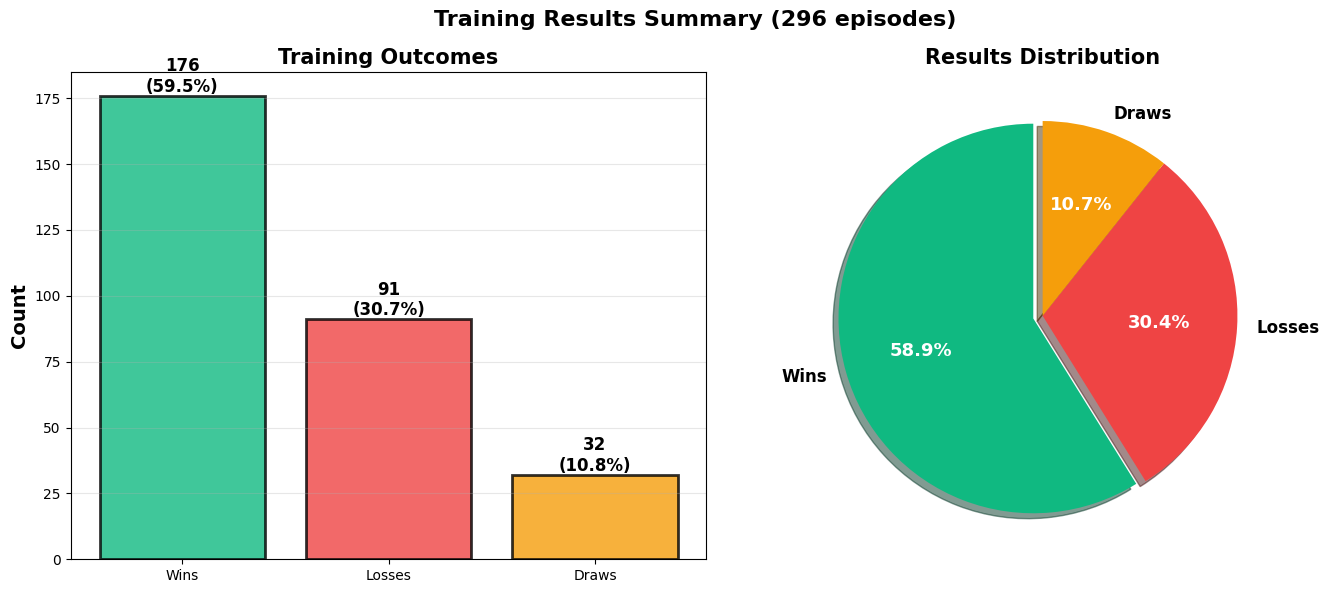


✅ Done! Check the generated PNG files.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pickle

def plot_training_results_from_scratch(wins, losses, draws, episodes, win_rates, loss_rates, draw_rates, episode_numbers):
    """
    Plot comprehensive training results
    
    Parameters:
    -----------
    wins : int - Total number of wins
    losses : int - Total number of losses
    draws : int - Total number of draws
    episodes : int - Total number of training episodes
    win_rates : list - Win rates over time
    loss_rates : list - Loss rates over time
    draw_rates : list - Draw rates over time
    episode_numbers : list - Episode numbers corresponding to rates
    """
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(18, 10))
    
    # ============= Plot 1: Performance Over Time (Line Chart) =============
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(episode_numbers, win_rates, label='Win Rate', 
             color='#10b981', linewidth=3, marker='o', markersize=3)
    ax1.plot(episode_numbers, loss_rates, label='Loss Rate', 
             color='#ef4444', linewidth=3, marker='s', markersize=3)
    ax1.plot(episode_numbers, draw_rates, label='Draw Rate', 
             color='#f59e0b', linewidth=3, marker='^', markersize=3)
    
    ax1.set_xlabel('Episodes', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Rate (%)', fontsize=14, fontweight='bold')
    ax1.set_title('Training Performance Over Time\n(Rolling 100-game average)', 
                  fontsize=15, fontweight='bold', pad=20)
    ax1.legend(fontsize=12, loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xlim(0, episodes)
    ax1.set_ylim(0, 100)
    
    # Add horizontal reference lines
    ax1.axhline(y=50, color='gray', linestyle=':', alpha=0.5, label='50% baseline')
    
    # ============= Plot 2: Final Results (Pie Chart) =============
    ax2 = plt.subplot(2, 3, 2)
    labels = ['Wins', 'Losses', 'Draws']
    sizes = [wins, losses, draws]
    colors = ['#10b981', '#ef4444', '#f59e0b']
    explode = (0.05, 0, 0)  # Explode wins slice
    
    wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, 
                                        colors=colors, autopct='%1.1f%%',
                                        shadow=True, startangle=90,
                                        textprops={'fontsize': 12, 'fontweight': 'bold'})
    
    # Make percentage text more visible
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(13)
        autotext.set_weight('bold')
    
    ax2.set_title('Final Training Results Distribution', 
                  fontsize=15, fontweight='bold', pad=20)
    
    # ============= Plot 3: Cumulative Performance (Stacked Area) =============
    ax3 = plt.subplot(2, 3, 3)
    
    # Calculate cumulative percentages
    win_cum = np.array(win_rates)
    loss_cum = np.array(loss_rates)
    draw_cum = np.array(draw_rates)
    
    ax3.fill_between(episode_numbers, 0, win_cum, 
                     color='#10b981', alpha=0.6, label='Win Rate')
    ax3.fill_between(episode_numbers, win_cum, win_cum + draw_cum, 
                     color='#f59e0b', alpha=0.6, label='Draw Rate')
    ax3.fill_between(episode_numbers, win_cum + draw_cum, 100, 
                     color='#ef4444', alpha=0.6, label='Loss Rate')
    
    ax3.set_xlabel('Episodes', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Rate (%)', fontsize=14, fontweight='bold')
    ax3.set_title('Stacked Performance Distribution', 
                  fontsize=15, fontweight='bold', pad=20)
    ax3.legend(fontsize=12, loc='best', framealpha=0.9)
    ax3.grid(True, alpha=0.3, linestyle='--', axis='x')
    ax3.set_xlim(0, episodes)
    ax3.set_ylim(0, 100)
    
    # ============= Plot 4: Bar Chart Comparison =============
    ax4 = plt.subplot(2, 3, 4)
    
    categories = ['Wins', 'Losses', 'Draws']
    values = [wins, losses, draws]
    bar_colors = ['#10b981', '#ef4444', '#f59e0b']
    
    bars = ax4.bar(categories, values, color=bar_colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/episodes*100:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax4.set_ylabel('Count', fontsize=14, fontweight='bold')
    ax4.set_title('Total Outcomes', fontsize=15, fontweight='bold', pad=20)
    ax4.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    # ============= Plot 5: Win Rate Trend Analysis =============
    ax5 = plt.subplot(2, 3, 5)
    
    # Plot win rate with confidence band
    ax5.plot(episode_numbers, win_rates, color='#10b981', linewidth=3, label='Win Rate')
    
    # Add moving average trend line
    if len(win_rates) > 10:
        window = 10
        moving_avg = np.convolve(win_rates, np.ones(window)/window, mode='valid')
        moving_avg_episodes = episode_numbers[window-1:]
        ax5.plot(moving_avg_episodes, moving_avg, 
                color='#064e3b', linewidth=2, linestyle='--', 
                label=f'{window}00-Episode Moving Avg', alpha=0.8)
    
    # Mark first and last values
    ax5.scatter([episode_numbers[0]], [win_rates[0]], 
               color='red', s=100, zorder=5, label='Start')
    ax5.scatter([episode_numbers[-1]], [win_rates[-1]], 
               color='blue', s=100, zorder=5, label='End')
    
    ax5.set_xlabel('Episodes', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Win Rate (%)', fontsize=14, fontweight='bold')
    ax5.set_title('Win Rate Progression & Trend', 
                  fontsize=15, fontweight='bold', pad=20)
    ax5.legend(fontsize=11, loc='best', framealpha=0.9)
    ax5.grid(True, alpha=0.3, linestyle='--')
    ax5.set_xlim(0, episodes)
    ax5.set_ylim(0, 100)
    
    # ============= Plot 6: Statistics Summary =============
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Calculate statistics
    final_win_rate = (wins / episodes) * 100
    final_loss_rate = (losses / episodes) * 100
    final_draw_rate = (draws / episodes) * 100
    
    if len(win_rates) > 0:
        initial_win_rate = win_rates[0] if len(win_rates) > 0 else 0
        final_rolling_win_rate = win_rates[-1] if len(win_rates) > 0 else 0
        improvement = final_rolling_win_rate - initial_win_rate
    else:
        initial_win_rate = 0
        final_rolling_win_rate = 0
        improvement = 0
    
    stats_text = f"""
    📊 TRAINING STATISTICS
    {'='*35}
    
    Total Episodes: {episodes:,}
    
    FINAL RESULTS:
    ✅ Wins:   {wins:5,} ({final_win_rate:5.1f}%)
    ❌ Losses: {losses:5,} ({final_loss_rate:5.1f}%)
    🤝 Draws:  {draws:5,} ({final_draw_rate:5.1f}%)
    
    PERFORMANCE METRICS:
    Initial Win Rate:  {initial_win_rate:5.1f}%
    Final Win Rate:    {final_rolling_win_rate:5.1f}%
    Improvement:       {improvement:+5.1f}%
    
    LEARNING EFFICIENCY:
    Win/Loss Ratio:    {wins/max(losses,1):5.2f}
    Success Rate:      {(wins+draws)/episodes*100:5.1f}%
    
    {'='*35}
    """
    
    ax6.text(0.1, 0.5, stats_text, 
            fontsize=12, 
            verticalalignment='center',
            family='monospace',
            bbox=dict(boxstyle='round', facecolor='#f0f0f0', 
                     alpha=0.8, edgecolor='black', linewidth=2))
    
    ax6.set_title('Summary Statistics', fontsize=15, fontweight='bold', pad=20)
    
    # ============= Overall Figure Settings =============
    fig.suptitle('🧠 Tic-Tac-Toe Q-Learning Agent - Complete Training Analysis', 
                fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save figure
    plt.savefig('comprehensive_training_results.png', dpi=300, bbox_inches='tight')
    print("✅ Comprehensive visualization saved as 'comprehensive_training_results.png'")
    
    plt.show()


def plot_simple_results(wins, losses, draws, episodes):
    """
    Simple 2-panel plot for quick visualization
    
    Parameters:
    -----------
    wins : int - Total number of wins
    losses : int - Total number of losses
    draws : int - Total number of draws
    episodes : int - Total number of training episodes
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Bar chart
    categories = ['Wins', 'Losses', 'Draws']
    values = [wins, losses, draws]
    colors = ['#10b981', '#ef4444', '#f59e0b']
    
    bars = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/episodes*100:.1f}%)',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax1.set_ylabel('Count', fontsize=14, fontweight='bold')
    ax1.set_title('Training Outcomes', fontsize=15, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Pie chart
    explode = (0.05, 0, 0)
    wedges, texts, autotexts = ax2.pie(values, explode=explode, labels=categories,
                                        colors=colors, autopct='%1.1f%%',
                                        shadow=True, startangle=90,
                                        textprops={'fontsize': 12, 'fontweight': 'bold'})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(13)
        autotext.set_weight('bold')
    
    ax2.set_title('Results Distribution', fontsize=15, fontweight='bold')
    
    plt.suptitle(f'Training Results Summary ({episodes:,} episodes)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    plt.savefig('simple_training_results.png', dpi=300, bbox_inches='tight')
    print("✅ Simple visualization saved as 'simple_training_results.png'")
    
    plt.show()


def load_and_plot_from_pickle(filename='training_data.pkl'):
    """
    Load training data from pickle file and plot
    
    Parameters:
    -----------
    filename : str - Name of pickle file containing training data
    """
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        print("📂 Loading training data...")
        wins = data['wins']
        losses = data['losses']
        draws = data['draws']
        episodes = data['episodes']
        win_rates = data['win_rates']
        loss_rates = data['loss_rates']
        draw_rates = data['draw_rates']
        episode_numbers = data['episode_numbers']
        
        print(f"✅ Data loaded: {episodes} episodes")
        print(f"   Wins: {wins}, Losses: {losses}, Draws: {draws}")
        
        plot_training_results_from_scratch(wins, losses, draws, episodes,
                                          win_rates, loss_rates, draw_rates,
                                          episode_numbers)
    except FileNotFoundError:
        print(f"❌ File '{filename}' not found!")
        print("Please provide the training data.")
    except Exception as e:
        print(f"❌ Error loading data: {e}")


# ============= EXAMPLE USAGE =============

if __name__ == "__main__":
    print("\n" + "="*60)
    print("📊 Tic-Tac-Toe Training Results Plotter")
    print("="*60)
    print("\nChoose an option:")
    print("1. Plot with example data (demo)")
    print("2. Plot with your custom data (enter manually)")
    print("3. Load from pickle file")
    print("="*60)
    
    choice = input("\nEnter choice (1-3): ")
    
    if choice == '1':
        # Example data for demonstration
        print("\n🎨 Creating demo visualization...")
        
        episodes = 10000
        wins = 7850
        losses = 1200
        draws = 950
        
        # Simulate progressive learning curve
        episode_numbers = list(range(100, episodes + 1, 100))
        
        # Simulate win rate improvement
        win_rates = []
        loss_rates = []
        draw_rates = []
        
        for ep in episode_numbers:
            progress = ep / episodes
            # Win rate improves from 30% to 78%
            win_rate = 30 + (48 * progress) + np.random.uniform(-3, 3)
            # Loss rate decreases from 50% to 12%
            loss_rate = 50 - (38 * progress) + np.random.uniform(-2, 2)
            # Draw rate stays relatively stable
            draw_rate = 100 - win_rate - loss_rate
            
            win_rates.append(max(0, min(100, win_rate)))
            loss_rates.append(max(0, min(100, loss_rate)))
            draw_rates.append(max(0, min(100, draw_rate)))
        
        plot_training_results_from_scratch(wins, losses, draws, episodes,
                                          win_rates, loss_rates, draw_rates,
                                          episode_numbers)
    
    elif choice == '2':
        # Custom data input
        print("\n📝 Enter your training results:")
        
        episodes = int(input("Total episodes: "))
        wins = int(input("Total wins: "))
        losses = int(input("Total losses: "))
        draws = int(input("Total draws: "))
        
        print("\n💡 For detailed plots, you need time-series data.")
        print("   If you don't have it, we'll create a simple plot.")
        
        has_timeseries = input("Do you have win/loss rates over time? (y/n): ")
        
        if has_timeseries.lower() == 'y':
            print("\nEnter comma-separated values:")
            episode_numbers = [int(x) for x in input("Episode numbers: ").split(',')]
            win_rates = [float(x) for x in input("Win rates (%): ").split(',')]
            loss_rates = [float(x) for x in input("Loss rates (%): ").split(',')]
            draw_rates = [float(x) for x in input("Draw rates (%): ").split(',')]
            
            plot_training_results_from_scratch(wins, losses, draws, episodes,
                                              win_rates, loss_rates, draw_rates,
                                              episode_numbers)
        else:
            plot_simple_results(wins, losses, draws, episodes)
    
    elif choice == '3':
        # Load from pickle
        filename = input("Enter pickle filename (default: training_data.pkl): ") or 'training_data.pkl'
        load_and_plot_from_pickle(filename)
    
    else:
        print("❌ Invalid choice!")
    
    print("\n✅ Done! Check the generated PNG files.")